# Evaluation of Best Model

## Initial Setup

In [1]:
# Import necessary libraries
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Create a folder path for saving evaluation plots
evaluation_plots_dir = "../figures/evaluation_plots"
os.makedirs(evaluation_plots_dir, exist_ok=True)

[INFO] Using device: mps


## Load Preprocessed Test Dataset

In [2]:
# Load the preprocessed test dataset
def load_csv_to_dataset(csv_path):
    """
    Loads data from a CSV file into a PyTorch TensorDataset.

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        TensorDataset: A dataset containing features and labels as tensors.
    """
    df = pd.read_csv(csv_path)
    labels = torch.tensor(df.iloc[:, 0].values, dtype=torch.long)
    features = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28)
    return TensorDataset(features, labels)

# Path to the test dataset
test_csv_path = "../data_preparation/test_data.csv"

# Load the test data
test_data = load_csv_to_dataset(test_csv_path)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"\n✅ Test data loaded successfully! Test samples: {len(test_data)}")



✅ Test data loaded successfully! Test samples: 10000


## Load the Best Model

In [3]:
# Add src folder to Python path to import model definitions
import sys
sys.path.insert(0, os.path.abspath("../src"))

from model_definitions import ResNet, BasicBlock

# Define the path to the best model weights and name
best_model_path = "../models/best_model_weights/best_model_weights.pth"
best_model_name = "ResNet"

# Function to load the best model
def load_best_model(best_model_name, best_model_path, num_classes=10):
    """
    Load the best model and its weights.
    
    Args:
        best_model_name: Name of the best model ("ResNet").
        best_model_path: Path to the best model weights.
        num_classes: Number of output classes.

    Returns:
        The loaded model set to evaluation mode.
    """
    if best_model_name == "ResNet":
        model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model name: {best_model_name}")

    model.load_state_dict(torch.load(best_model_path, weights_only= True))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    print(f"✅ {best_model_name} loaded successfully from: {best_model_path}")
    return model

# Load the best model
best_model = load_best_model(best_model_name, best_model_path)


✅ ResNet loaded successfully from: ../models/best_model_weights/best_model_weights.pth


## Evaluate the Best Model

### Evaluation Function

In [4]:
# Function to evaluate the model and collect predictions and true labels
def evaluate_model_with_confusion_matrix(model, dataloader, device):
    """
    Evaluates the model and collects predictions and true labels.

    Args:
        model: The trained model to evaluate.
        dataloader: DataLoader for the dataset to evaluate.
        device: Device for computation (e.g., "cuda", "cpu").

    Returns:
        Tuple of (loss, accuracy, all predictions, all true labels).
    """
    model.eval()  # Set model to evaluation mode
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            total_loss += loss.item()

            # Get predictions
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            total_correct += (y_pred == y).sum().item()

            # Collect predictions and true labels
            all_preds.extend(y_pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels)

### Performance Evaluation

In [5]:
# Evaluate the best model and collect predictions
test_loss, test_accuracy, predictions, true_labels = evaluate_model_with_confusion_matrix(
    best_model, test_loader, device
)
print(f"\n🎯 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



🎯 Test Loss: 0.2104, Test Accuracy: 0.9323


## Generate Confusion Matrix

✅ Confusion matrix saved at: ../figures/evaluation_plots/Best_ResNet_confusion_matrix.png


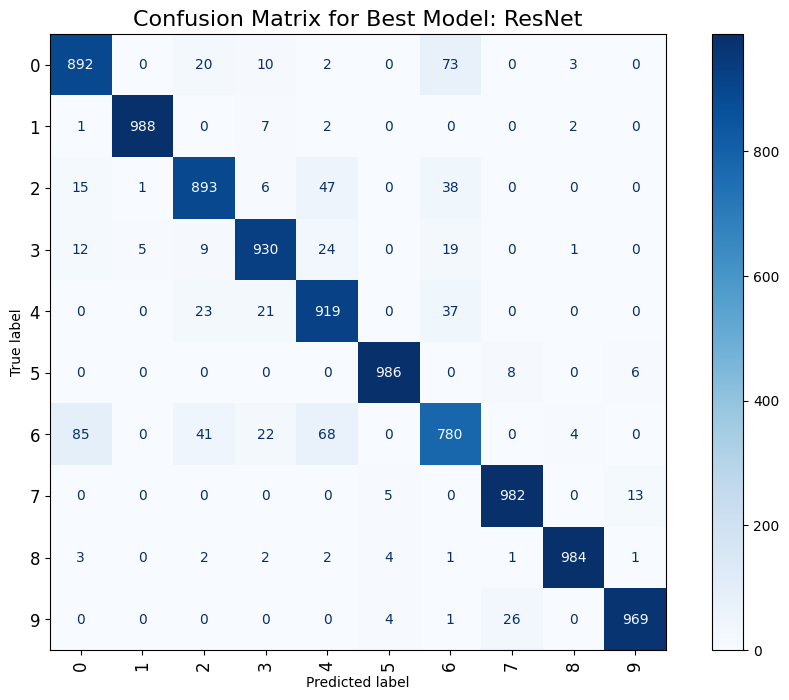

In [6]:
# Define evaluation plots directory
evaluation_plots_dir = "../figures/evaluation_plots"

# Create a variable to store number of classes
NUM_CLASSES = 10

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(NUM_CLASSES)))

# Increase the figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
disp.plot(cmap="Blues", xticks_rotation="vertical", ax=plt.gca())  # Use current axis to retain size
plt.title(f"Confusion Matrix for Best Model: {best_model_name}", fontsize=16)  # Increase title font size
plt.xticks(fontsize=12)  # Adjust font size for x-axis labels
plt.yticks(fontsize=12)  # Adjust font size for y-axis labels

# Save the confusion matrix plot with the updated filename
confusion_matrix_filename = "Best_ResNet_confusion_matrix.png"
confusion_matrix_path = os.path.join(evaluation_plots_dir, confusion_matrix_filename)
plt.savefig(confusion_matrix_path, bbox_inches="tight")
print(f"✅ Confusion matrix saved at: {confusion_matrix_path}")

# Display the plot
plt.show()

## Compute Metrics (Compute Metrics (Precision, Recall, F1-Score, Accuracy))

In [7]:
# Calculate individual metrics
precision = precision_score(true_labels, predictions, average="weighted")  # Weighted precision
recall = recall_score(true_labels, predictions, average="weighted")        # Weighted recall
f1 = f1_score(true_labels, predictions, average="weighted")                # Weighted F1-score
accuracy = accuracy_score(true_labels, predictions)                        # Accuracy

# Print metrics
print(f"\n📌 Best Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


📌 Best Model Evaluation Metrics:
Accuracy: 0.9323
Precision: 0.9323
Recall: 0.9323
F1-Score: 0.9321


## Visualize Predictions

✅ Prediction visualization saved at: ../figures/evaluation_plots/prediction_visualization.png


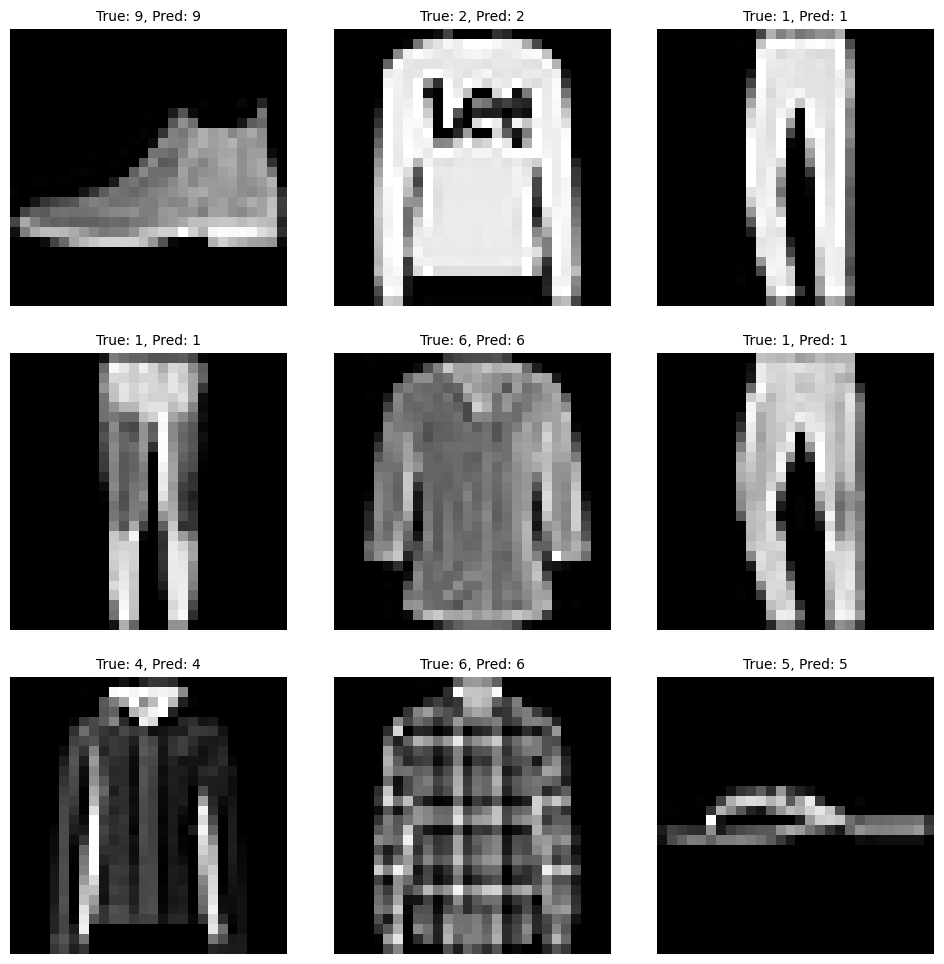

In [8]:
# Function to visualize some predictions
def visualize_predictions(model, dataloader, device, class_names=None, filename="prediction_visualization.png"):
    """
    Visualize a few predictions with their true labels in a 3x3 grid and save the plot.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: The device to compute on.
        class_names: Optional list of class names.
        filename: Name of the file to save the plot as.
    """
    model.eval()
    X_batch, y_batch = next(iter(dataloader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.inference_mode():
        y_logits = model(X_batch)
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # Plot the first 9 images
    plt.figure(figsize=(10, 10))  # Adjust figure size for better appearance
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i].squeeze().cpu(), cmap="gray")
        title = f"True: {y_batch[i].item()}, Pred: {y_pred[i].item()}"
        if class_names:
            title = f"True: {class_names[y_batch[i].item()]}, Pred: {class_names[y_pred[i].item()]}"
        plt.title(title, fontsize=10)  # Add smaller titles for readability
        plt.axis("off")
    plt.tight_layout(pad=2.0)  # Add padding between plots for better visibility

    # Save the plot to the evaluation_plots_dir
    save_path = os.path.join(evaluation_plots_dir, filename)
    plt.savefig(save_path, bbox_inches="tight")
    print(f"✅ Prediction visualization saved at: {save_path}")
    plt.show()


# Usage
evaluation_plots_dir = "../figures/evaluation_plots"
visualize_predictions(best_model, test_loader, device, filename="prediction_visualization.png")

## Plotting confusion matrix and calculating evaluation metrics for the Baseline ResNet model 

In [9]:
# Function to load the baseline ResNet model
def load_baseline_resnet(baseline_model_path, num_classes=10):
    """
    Load the baseline ResNet model and its weights.

    Args:
        baseline_model_path: Path to the baseline ResNet model weights.
        num_classes: Number of output classes.

    Returns:
        The loaded model set to evaluation mode.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    model.load_state_dict(torch.load(baseline_model_path, weights_only=True))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    print(f"✅ Baseline ResNet loaded successfully from: {baseline_model_path}")
    return model

In [10]:
# Section: Baseline ResNet Evaluation
print("\n--- Baseline ResNet Evaluation ---")

# Step 1: Load the baseline ResNet model
baseline_model_path = "../models/all_models/resnet_model_weights.pth"
baseline_resnet = load_baseline_resnet(baseline_model_path)

# Step 2: Evaluate the baseline ResNet
baseline_loss, baseline_accuracy, baseline_predictions, baseline_true_labels = evaluate_model_with_confusion_matrix(
    baseline_resnet, test_loader, device
)

# Step 3: Print metrics for the baseline ResNet
print(f"\n🎯 Baseline ResNet Metrics:")
print(f"Test Loss: {baseline_loss:.4f}")
print(f"Test Accuracy: {baseline_accuracy:.4f}")


--- Baseline ResNet Evaluation ---
✅ Baseline ResNet loaded successfully from: ../models/all_models/resnet_model_weights.pth

🎯 Baseline ResNet Metrics:
Test Loss: 0.2688
Test Accuracy: 0.9094


In [11]:
# Generate precision, recall, and F1-score
baseline_precision = precision_score(baseline_true_labels, baseline_predictions, average="weighted")
baseline_recall = recall_score(baseline_true_labels, baseline_predictions, average="weighted")
baseline_f1 = f1_score(baseline_true_labels, baseline_predictions, average="weighted")

print(f"\n📌 Baseline Evaluation Metrics:")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"F1-Score: {baseline_f1:.4f}")


📌 Baseline Evaluation Metrics:
Precision: 0.9116
Recall: 0.9094
F1-Score: 0.9095


✅ Baseline ResNet confusion matrix saved at: ../figures/evaluation_plots/Baseline_ResNet_confusion_matrix.png


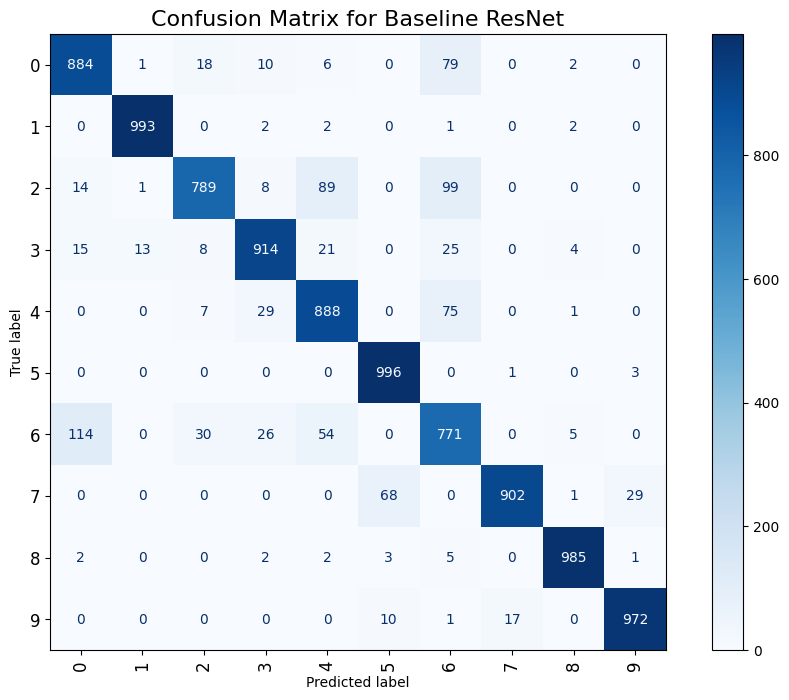

In [12]:
# Step 4: Plot and save confusion matrix for baseline ResNet
baseline_cm = confusion_matrix(baseline_true_labels, baseline_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=list(range(NUM_CLASSES)))

# Set figure size and plot
plt.figure(figsize=(12, 8))
disp.plot(cmap="Blues", xticks_rotation="vertical", ax=plt.gca())
plt.title("Confusion Matrix for Baseline ResNet", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save confusion matrix for baseline ResNet
baseline_cm_filename = "Baseline_ResNet_confusion_matrix.png"
baseline_cm_path = os.path.join(evaluation_plots_dir, baseline_cm_filename)
plt.savefig(baseline_cm_path, bbox_inches="tight")
print(f"✅ Baseline ResNet confusion matrix saved at: {baseline_cm_path}")

# Display the plot
plt.show()

## Comparison of Baseline and Fine-Tuned ResNet Models

### Evaluation Metrics Comparison
| Metric        | Baseline ResNet | Fine-Tuned ResNet |
|---------------|-----------------|-------------------|
| **Accuracy**  | 0.9094          | 0.9323           |
| **Precision** | 0.9116          | 0.9323           |
| **Recall**    | 0.9094          | 0.9323           |
| **F1-Score**  | 0.9095          | 0.9321           |

**Observation**:  
- The fine-tuned ResNet model outperformed the baseline ResNet across all evaluation metrics.  
- The improvement in F1-score demonstrates the fine-tuned model's enhanced ability to classify with balanced precision and recall.  
- Accuracy increased significantly, reflecting better overall predictions.

---

### Confusion Matrix Comparison

1. **Baseline ResNet Confusion Matrix**  
   - Observations:
     - The baseline model misclassified certain classes more frequently.
     - Performance was lower in challenging classes with high variability.

   ![Baseline Confusion Matrix](../figures/evaluation_plots/Baseline_ResNet_confusion_matrix.png)

2. **Fine-Tuned ResNet Confusion Matrix**  
   - Observations:
     - The fine-tuned model reduced misclassifications and achieved higher true positive rates.
     - Classes with lower representation showed significant improvement.  

   ![Fine-Tuned Confusion Matrix](../figures/evaluation_plots/Best_ResNet_confusion_matrix.png)

---

### Visualized Predictions
Below are visualized predictions from the fine-tuned ResNet model.  
These predictions show how the model correctly classified even challenging examples, demonstrating its improved capability after fine-tuning.

---

### Key Insights

- **Metric Performance**: The fine-tuned ResNet surpassed the baseline in all metrics, with notable improvements in precision and recall.
- **Confusion Matrix**: The fine-tuned model achieved fewer misclassifications, especially in critical or difficult-to-predict classes.
- **Generalization**: Fine-tuning enhanced the model's generalization and adaptability to the dataset, indicating the success of the hyperparameter tuning process.